In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import dask.array as da

#Package to suppress Python warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Constants
nx, ny, nz = 256, 256, 64
date = 20221230
bc = '_DCa'
days = [0, 100]
timesteps = np.arange(1080*8*(days[0]), 1080*8*(days[1])+1, 1080)[1:]

In [3]:
# Physical constants
Cp = 1004
g = 9.81
Lf = 0.3336e+06  # Latent heat of fusion, J/kg
Ls = 2.8440e+06  # Latent heat of sublimation, J/kg
Lv = Ls - Lf     # Latent heat of vaporization

In [4]:
# File paths and job naming
job = f'SAM6108_RCE_MC_{date:08d}_{nx:03d}x{ny:03d}{bc}'
path = f'/fs3/group/mullegrp/Bidyut_Goswami/sam_data/{job}/OUT_{job}/NETCDF_files/'

In [5]:
# Read 1D nc files
f_1D = xr.open_dataset(f'{path}RCE_MC_{job}.nc')
TABS1D, THETA1D, plev1D, z1D = f_1D['TABS'], f_1D['THETA'], f_1D['p'], f_1D['z']

In [6]:
# Find height index close to 3000m
height = 3000  # meters
hidx = np.abs(z1D.values - height).argmin()
print(f"Height index: {hidx}, Pressure: {plev1D[hidx].values}, Height: {z1D[hidx].values}")

Height index: 14, Pressure: 709.8908081054688, Height: 3021.260009765625


In [7]:
# Read 2D nc files and concatenate along time dimension
def read_2D_files(var_name, num_files):
    data = []
    for i in range(1, num_files+1):
        f_2D = xr.open_dataset(f'{path}RCE_MC_{job}_{nz}.2Dcom_{i}.nc')
        data.append(f_2D[var_name])
    return xr.concat(data, dim='time')

MSE2D = read_2D_files('MSE', 3)
W5k2D = read_2D_files('W5km', 3)
IntQN2D = read_2D_files('IntQN', 3)

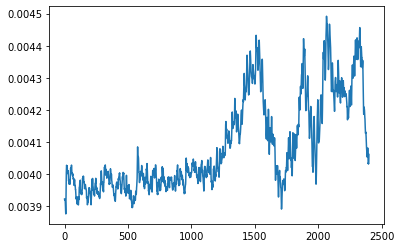

In [8]:

# Read 3D nc files for specified timesteps and height index
def read_3D_files(var_name, timesteps, z_idx):
    data = []
    for ts in timesteps:
        f_3D = xr.open_dataset(f'{path}RCE_MC_{job}_{nz}_{ts:010d}.nc')
        data.append(f_3D[var_name][:, z_idx, :, :])
    return xr.concat(data, dim='time')

W500 = read_3D_files('W', timesteps, hidx) #NOTE: hidx is for 3km height. variable name W500 is somewhat misleading.
TABS500 = read_3D_files('TABS', timesteps, hidx)
QRAD500 = read_3D_files('QRAD', timesteps, hidx)
QN500 = read_3D_files('QN', timesteps, hidx)

# Calculate dTheta/dz and Gamma
TAB1D_53, THETA1D_53 = TABS1D[:, :53], THETA1D[:, :53]
dThetadz = np.diff(THETA1D_53, axis=1) / np.diff(THETA1D_53['z'].values)
Gamma = (TAB1D_53[:, hidx] / THETA1D_53[:, hidx]) * dThetadz[:, hidx]
plt.plot(Gamma)

In [9]:
# print(RHO1D_53.shape)
print(MSE2D.shape)
print(W500.shape)
print(TABS500.shape)
print(QRAD500.shape)
print(Gamma.shape)
print(QN500.shape)

(2400, 256, 256)
(800, 256, 256)
(800, 256, 256)
(800, 256, 256)
(2400,)
(800, 256, 256)


In [10]:
# Convert NumPy arrays to Dask arrays
def to_dask_array(data):
    return da.from_array(data, chunks=(800,) + data.shape[1:])

MSE2D_dask = to_dask_array(MSE2D.values)
W5k2D_dask = to_dask_array(W5k2D.values)
IntQN2D_dask = to_dask_array(IntQN2D.values)
Gamma_dask = to_dask_array(Gamma)

# Convert for shorter time step data
W500_dask = da.from_array(W500.values, chunks=(800,) + W500.shape[1:])
TABS500_dask = da.from_array(TABS500.values, chunks=(800,) + TABS500.shape[1:])
QRAD500_dask = da.from_array(QRAD500.values, chunks=(800,) + QRAD500.shape[1:])
QN500_dask = da.from_array(QN500.values, chunks=(800,) + QN500.shape[1:])

# Reshape data for daily averages
def reshape_for_averaging(data, steps):
    shape = (data.shape[0] // steps, steps) + data.shape[1:]
    return da.reshape(data[:shape[0] * steps], shape)

# Calculate daily averages for datasets with 2400 and 800 time steps
dailyMSE = da.mean(reshape_for_averaging(MSE2D_dask, 24), axis=1)
dailyW5k = da.mean(reshape_for_averaging(W5k2D_dask, 24), axis=1)
dailyIntQN2D = da.mean(reshape_for_averaging(IntQN2D_dask, 24), axis=1)

#dailyGamma = da.mean(reshape_for_averaging(Gamma_dask, 24), axis=1)
dailyGammatmp=np.reshape(Gamma.values,(np.int(Gamma.shape[0]/100),100),order='F') #The above step gives an error
dailyGamma=np.mean(dailyGammatmp,0)

dailyW500 = da.mean(reshape_for_averaging(W500_dask, 8), axis=1)
dailyTABS500 = da.mean(reshape_for_averaging(TABS500_dask, 8), axis=1)
dailyQRAD500 = da.mean(reshape_for_averaging(QRAD500_dask, 8), axis=1)
dailyQN500 = da.mean(reshape_for_averaging(QN500_dask, 8), axis=1)


#Printing shape of reshaped arrays
names = ["dailyMSE", "dailyW5k", "dailyGamma", "dailyW500", "dailyTABS500", "dailyQRAD500", "dailyQN500"]
arrays = [dailyMSE, dailyW5k, dailyGamma, dailyW500, dailyTABS500, dailyQRAD500, dailyQN500]
print("Shapes after reshaping:")
max_name_length = max(len(name) for name in names)
for name, array in zip(names, arrays):
    print(f"{name.ljust(max_name_length)} : {array.shape}")



Shapes after reshaping:
dailyMSE     : (100, 256, 256)
dailyW5k     : (100, 256, 256)
dailyGamma   : (100,)
dailyW500    : (100, 256, 256)
dailyTABS500 : (100, 256, 256)
dailyQRAD500 : (100, 256, 256)
dailyQN500   : (100, 256, 256)


In [11]:
# Calculate daily temperature change
dT = da.diff(dailyTABS500, axis=0, prepend=dailyTABS500[:1, :, :]) / 86400
dT = dT[:100, :, :]

# Flatten data for sorting
def flatten_data(data):
    return da.reshape(data, (data.shape[0], -1))

Flattened_dailyMSE = flatten_data(dailyMSE)
Flattened_dailyW5k = flatten_data(dailyW5k)
Flattened_dailyIntQN2D = flatten_data(dailyIntQN2D)
Flattened_dailyW500 = flatten_data(dailyW500)
Flattened_dailyQRAD500 = flatten_data(dailyQRAD500)
Flattened_dailyQN500 = flatten_data(dailyQN500)
Flattened_dT = flatten_data(dT)

flattened_arrays = {
    "Flattened_dailyMSE": Flattened_dailyMSE,
    "Flattened_dailyW5k": Flattened_dailyW5k,
    "Flattened_dailyIntQN2D": Flattened_dailyIntQN2D,
    "Flattened_dailyW500": Flattened_dailyW500,
    "Flattened_dailyQRAD500": Flattened_dailyQRAD500,
    "Flattened_dailyQN500": Flattened_dailyQN500,
    "Flattened_dT": Flattened_dT
}

print("Shapes of flattened arrays:")
max_name_length = max(len(name) for name in flattened_arrays)
for name, array in flattened_arrays.items():
    print(f"{name.ljust(max_name_length)} : {array.shape[0]},{array.shape[1]}")


Shapes of flattened arrays:
Flattened_dailyMSE     : 100,65536
Flattened_dailyW5k     : 100,65536
Flattened_dailyIntQN2D : 100,65536
Flattened_dailyW500    : 100,65536
Flattened_dailyQRAD500 : 100,65536
Flattened_dailyQN500   : 100,65536
Flattened_dT           : 100,65536


In [12]:
sorted_dailyW5k = Flattened_dailyW5k.copy()
sorted_dailyIntQN2D = Flattened_dailyIntQN2D.copy()
sorted_dailyW500 = Flattened_dailyW500.copy()
sorted_dailyQRAD500 = Flattened_dailyQRAD500.copy()
sorted_dailyQN500 = Flattened_dailyQN500.copy()
sorted_dT = Flattened_dT.copy()


for tt in range(Flattened_dailyMSE.shape[0]):
    copyMSE = Flattened_dailyMSE[tt, :].copy()
    sorted_idx = np.argsort(copyMSE)  # LOCATION
    sorted_dailyMSE = np.sort(copyMSE)

    ttW5 = Flattened_dailyW5k[tt, :]
    ttW5 = ttW5[sorted_idx]
    sorted_dailyW5k[tt, :] = ttW5

    ttQN = Flattened_dailyIntQN2D[tt, :]
    ttQN = ttQN[sorted_idx]
    sorted_dailyIntQN2D[tt, :] = ttQN

    ttW = Flattened_dailyW500[tt, :]
    ttW = ttW[sorted_idx]
    sorted_dailyW500[tt, :] = ttW

    ttQRAD = Flattened_dailyQRAD500[tt, :]
    ttQRAD = ttQRAD[sorted_idx]
    sorted_dailyQRAD500[tt, :] = ttQRAD

    ttdT = Flattened_dT[tt, :]
    ttdT = ttdT[sorted_idx]
    sorted_dT[tt, :] = ttdT

    
    
sorted_arrays = {
    "sorted_dailyMSE": sorted_dailyMSE,
    "sorted_dailyW5k": sorted_dailyW5k,
    "sorted_dailyIntQN2D": sorted_dailyIntQN2D,
    "sorted_dailyW500": sorted_dailyW500,
    "sorted_dailyQRAD500": sorted_dailyQRAD500,
    "sorted_dailyQN500": sorted_dailyQN500,
    "sorted_dT": sorted_dT
}

print("Shapes of sorted arrays:")
max_name_length = max(len(name) for name in sorted_arrays)
for name, array in sorted_arrays.items():
    print(f"{name.ljust(max_name_length)} : {array.shape}")


Shapes of sorted arrays:
sorted_dailyMSE     : (65536,)
sorted_dailyW5k     : (100, 65536)
sorted_dailyIntQN2D : (100, 65536)
sorted_dailyW500    : (100, 65536)
sorted_dailyQRAD500 : (100, 65536)
sorted_dailyQN500   : (100, 65536)
sorted_dT           : (100, 65536)


In [14]:
# MSE25 is the 25th percentile values of sorted_dailyMSE
# i25 is the index of MSE25
# W5kdry, W500dry, QRAD500dry, dTdry are respective mean values below i25
# => meaning, values at grids corresponding to driest MSE values (clear sky)

MSE25 = np.percentile(sorted_dailyMSE, 25)

i25 = np.where(sorted_dailyMSE<MSE25)
print(i25)

W5kdry=sorted_dailyW5k[:,i25[0]].mean(1)
W500dry=sorted_dailyW500[:,i25[0]].mean(1)
QRAD500dry=sorted_dailyQRAD500[:,i25[0]].mean(1)
dTdry=sorted_dT[:,i25[0]].mean(1)

(array([    0,     1,     2, ..., 16380, 16381, 16382]),)


Text(0.5, 1.0, 'sorted MSE')

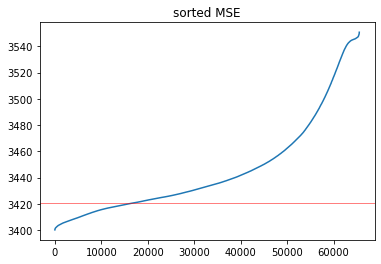

In [15]:
plt.plot(sorted_dailyMSE)
plt.axhline(MSE25,color='r',linewidth=0.5)
plt.title("sorted MSE")

In [16]:
#Need this step to convert dask to numpy for plotting

W500dry_c    =W500dry.compute()
W5kdry_c     =W5kdry.compute()
QRAD500dry_c =QRAD500dry.compute()
dTdry_c      =dTdry.compute()
dailyGamma_c =dailyGamma

In [17]:
dailyGamma_c.shape

(100,)

Text(0.5, 1.0, 'mean -QRAD500dry K/day')

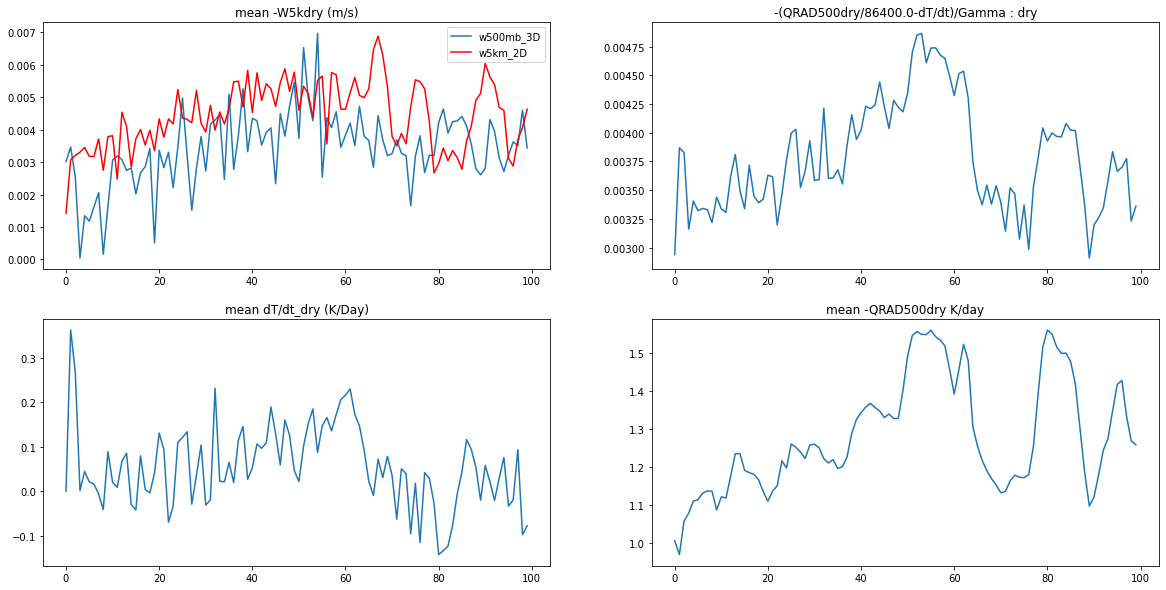

In [18]:
fig, axl = plt.subplots(2,2, figsize=(20, 10))

#axl[0,0].plot(-W5kdry)

axl[0,0].plot(-W500dry_c,label='w500mb_3D')
axl[0,0].plot(-W5kdry_c, color = 'r',label='w5km_2D')
#axl[0,0].set_ylim(0.0,0.010)
axl[0,0].set_title("mean -W5kdry (m/s)")
axl[0,0].legend()


axl[0,1].plot(-(QRAD500dry_c/86400.0-dTdry_c)/dailyGamma_c)
#axl[0,1].set_ylim(0.0,0.010)
axl[0,1].set_title("-(QRAD500dry/86400.0-dT/dt)/Gamma : dry")

axl[1,0].plot(dTdry_c*86400.0)
#axl[1,0].set_ylim(-0.25,2.0)
axl[1,0].set_title("mean dT/dt_dry (K/Day)")

axl[1,1].plot(-QRAD500dry_c)
#axl[1,1].set_ylim(-0.25,2.0)
axl[1,1].set_title("mean -QRAD500dry K/day")



In [19]:
#Storing the variables
W5kdry_EXPTsw=W500dry_c.copy()
QRAD500dry_EXPTsw=QRAD500dry_c.copy()
dTdry_EXPTsw=dTdry_c.copy()
Gamma_EXPTsw=dailyGamma_c.copy()

%store W5kdry_EXPTsw
%store QRAD500dry_EXPTsw
%store dTdry_EXPTsw
%store Gamma_EXPTsw

Stored 'W5kdry_EXPTsw' (ndarray)
Stored 'QRAD500dry_EXPTsw' (ndarray)
Stored 'dTdry_EXPTsw' (ndarray)
Stored 'Gamma_EXPTsw' (ndarray)
